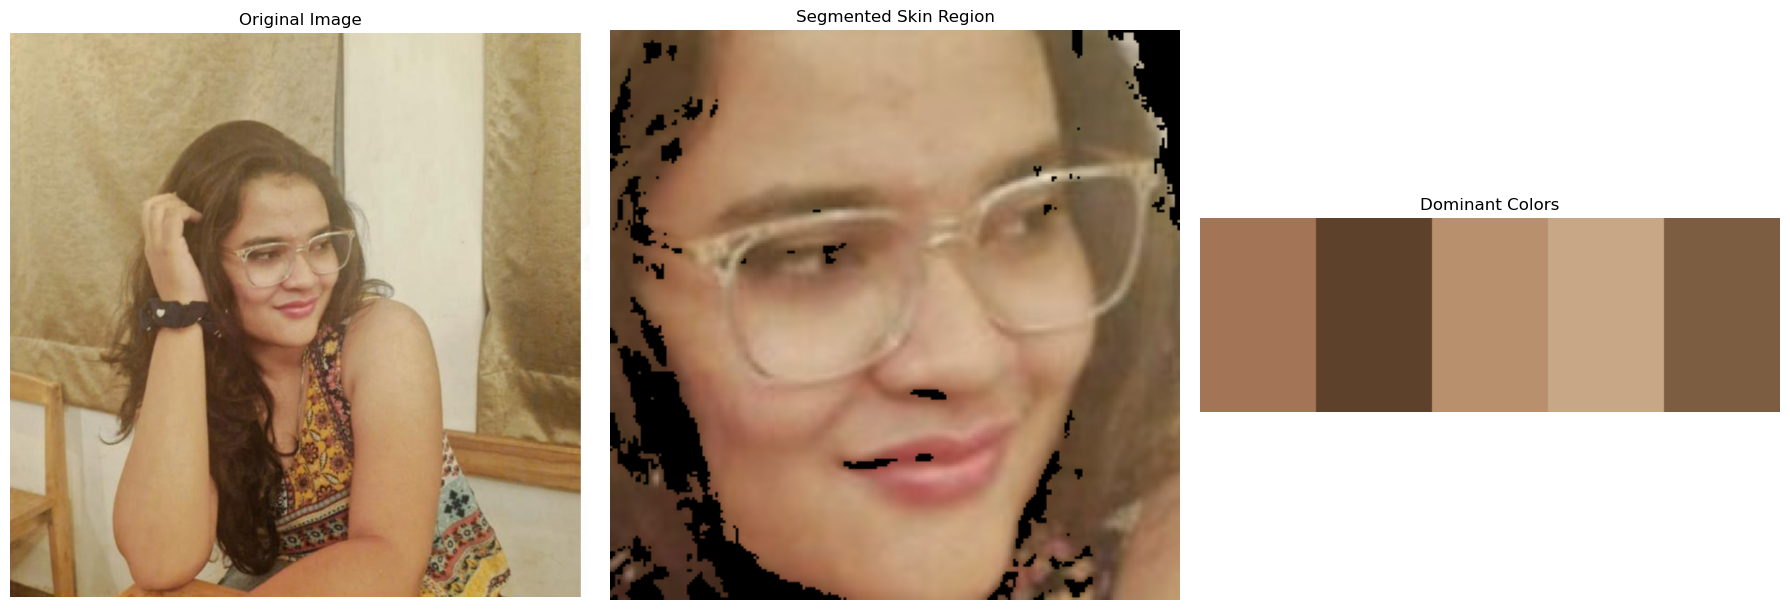

Predicted Skin Tone: medium
Recommended Colors: ['ruby red', 'emerald green', 'royal blue']


In [90]:
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the pre-trained face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to detect the face
def detect_face(image_rgb):
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if len(faces) == 0:
        raise ValueError("No faces detected")
    return faces[0]

# Function to segment the skin region
def segment_skin(image_rgb, face):
    x, y, w, h = face
    roi_color = image_rgb[y:y+h, x:x+w]
    
    # Convert face region to HSV for better skin tone extraction
    hsv_roi = cv2.cvtColor(roi_color, cv2.COLOR_RGB2HSV)
    
    # Improved HSV range for skin color detection
    lower_hsv = np.array([0, 10, 60])
    upper_hsv = np.array([20, 150, 255])
    
    # Create a mask for skin color
    mask = cv2.inRange(hsv_roi, lower_hsv, upper_hsv)
    
    skin_region = cv2.bitwise_and(roi_color, roi_color, mask=mask)
    return skin_region

# Function to preprocess image and extract features
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    face = detect_face(image_rgb)
    skin_region = segment_skin(image_rgb, face)
    dominant_colors = extract_dominant_colors(skin_region)
    return image_rgb, skin_region, dominant_colors

# Function to extract dominant colors using K-means clustering
def extract_dominant_colors(image):
    pixels = image.reshape((-1, 3))
    pixels = pixels[np.all(pixels != [0, 0, 0], axis=1)]  # Remove black pixels (background)
    
    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans.fit(pixels)
    dominant_colors = kmeans.cluster_centers_
    return dominant_colors

# Function to predict skin tone using SVM classifier
def predict_skin_tone(dominant_colors):
    # Example dataset (replace with your actual skin tone dataset)
    data = {
        'skin_color': [[255, 224, 189], [242, 214, 189], [198, 134, 66], [141, 85, 36]], # RGB values
        'skin_tone': ['fair', 'light', 'medium', 'dark']
    }

    X = np.array(data['skin_color'])
    y = np.array(data['skin_tone'])

    # Use a pipeline for scaling and SVM classification
    pipeline = Pipeline([
        ('scaling', StandardScaler()),
        ('svm', SVC(kernel='rbf', C=1, gamma='scale', random_state=42))
    ])

    pipeline.fit(X, y)
    predicted_tone = pipeline.predict(dominant_colors)
    return predicted_tone[0]

# Recommendations for skin tones
recommendations = {
    'fair': ['pastel pink', 'light blue', 'mint green'],
    'light': ['peach', 'coral', 'warm grey'],
    'medium': ['ruby red', 'emerald green', 'royal blue'],
    'dark': ['gold', 'bright yellow', 'purple']
}

# Function to recommend colors based on predicted skin tone
def recommend_colors(predicted_skin_tone):
    recommended_colors = recommendations.get(predicted_skin_tone, [])
    return recommended_colors

# Function to display original, segmented skin region, and dominant colors
def display_segmented_skin(image_path):
    original_image, skin_region, dominant_colors = preprocess_image(image_path)

    # Display images and dominant colors
    plt.figure(figsize=(18, 6))

    # Display original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    # Display segmented skin region
    plt.subplot(1, 3, 2)
    plt.imshow(skin_region)
    plt.title('Segmented Skin Region')
    plt.axis('off')

    # Display dominant colors
    plt.subplot(1, 3, 3)
    color_palette = np.zeros((100, 300, 3), dtype=np.uint8)
    start = 0
    for idx, color in enumerate(dominant_colors):
        end = start + int(300 / len(dominant_colors))
        color_palette[:, start:end, :] = np.array(color, dtype=np.uint8)[np.newaxis, np.newaxis, :]
        start = end
    plt.imshow(color_palette)
    plt.title('Dominant Colors')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage with display of original image, segmented skin region, and dominant colors
image_path = r'ss.jpeg'
display_segmented_skin(image_path)

# Predict skin tone and recommend colors
_, _, dominant_colors = preprocess_image(image_path)
predicted_skin_tone = predict_skin_tone(dominant_colors)

print("Predicted Skin Tone:", predicted_skin_tone)
if predicted_skin_tone:
    recommended_colors = recommend_colors(predicted_skin_tone)
    print("Recommended Colors:", recommended_colors)
else:
    print("Skin tone prediction failed.")